In [1]:
import pandas as pd
import sys
import os
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if path not in sys.path:
    sys.path.append(path)
from constants import NER
# get the first key in NERa
from fuzzywuzzy import fuzz
from constants import NER
from fuzzywuzzy import fuzz
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
# import sklearn_crfsuite
import sklearn_crfsuite
from joblib import Parallel, delayed
import multiprocessing
from transformers import pipeline
from utils.helpers import combine_sub_words
from transformers import AutoTokenizer, AutoModelForTokenClassification

from custom_transformers.CustomTransformers import Cleaner , ReplyFinder ,CombineMessageReply



c:\Users\nasser\.conda\envs\finall\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# df = pd.read_csv('../data/raw.csv')

In [3]:
# df = df.sample(1000)

In [4]:
# df.head(1)

,_,id,peer_id,date,message,out,mentioned,media_unread,silent,post,...,entities,views,forwards,replies,edit_date,post_author,grouped_id,reactions,restriction_reason,ttl_period
0,Message,428911,"{'_': 'PeerChannel', 'channel_id': 1756020315}",2023-03-17 11:04:46+00:00,الدي سي اوه عليه مشاكل ؟؟,False,False,False,False,False,...,[],NaN,NaN,"{'_': 'MessageReplies', 'replies': 0, 'replies...",NaN,NaN,NaN,NaN,[],86400.0


In [5]:
# cleaner = Cleaner()
# df = cleaner.transform(df)
# df.head(1)

Current step: Cleaner


,id,message,reply_to
0,428911,الدي سي اوه مشاكل ؟؟,NaN


In [6]:
# reply_finder = ReplyFinder()
# df = reply_finder.transform(df)
# df.head(1)

Current step: ReplyFinder


,message,reply_to
0,الدي سي اوه مشاكل ؟؟,


In [7]:
# combine_message_reply = CombineMessageReply()
# df = combine_message_reply.transform(df)
# df.head(2)

Current step: CombineMessageReply


,full_text
0,الدي سي اوه مشاكل ؟؟
1,شباب طريق جنين قلقيلة شو وضعها


In [8]:
# df.shape

(96290, 1)

In [9]:
# def process_word(word, NER):
#     for key in NER.keys():
#         if any(fuzz.ratio(word, k) >= 80 for k in key):
#             return NER[key]
#     return "O"

In [10]:
# def generate_ner_string(text, NER):
#     num_cores = multiprocessing.cpu_count()
#     words = text.split()
#     results = Parallel(n_jobs=num_cores)(
#         delayed(process_word)(word, NER) for word in words)
#     return " ".join(results)

In [11]:
# from tqdm.notebook import tqdm_notebook



# # Apply tqdm to the loop
# df['ner'] = Parallel(n_jobs=-1)(
#     delayed(generate_ner_string)(text, NER) for text in tqdm_notebook(df['full_text']))

  0%|          | 0/96290 [00:00<?, ?it/s]

In [14]:
# # get the rows with empty ner ""
# df[df['ner'] == '']
# # drop the rows with empty ner
# df = df[df['ner'] != '']

In [15]:
# df.to_csv('../data/data_with_near_finall.csv', index=False)

In [2]:
df = pd.read_csv('../data/data_with_near_finall.csv')

In [3]:
df.shape

(95257, 2)

In [4]:
data = df

In [5]:
data['ner'] = data['ner'].astype(str)
data['ner'] = data['ner'].apply(lambda x: x.split())

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
# Split the data into training and validation datasets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
# Tokenize the input sequence
input_tokenizer = Tokenizer( oov_token='UNK')
input_tokenizer.fit_on_texts(train_data['full_text'])
train_input_seq = input_tokenizer.texts_to_sequences(train_data['full_text'])
val_input_seq = input_tokenizer.texts_to_sequences(val_data['full_text'])

In [8]:
train_data.shape , val_data.shape

((76205, 2), (19052, 2))

In [9]:
# Tokenize the output sequence
output_tokenizer = Tokenizer(filters='', lower=False)
output_tokenizer.fit_on_texts(train_data['ner'])
train_output_seq = output_tokenizer.texts_to_sequences(train_data['ner'])
val_output_seq = output_tokenizer.texts_to_sequences(val_data['ner'])

In [10]:
# Create word to index and index to word mappings for the input sequence
input_word2idx = input_tokenizer.word_index
input_idx2word = {idx: word for word, idx in input_word2idx.items()}

In [11]:
# Create named entity to index and index to named entity mappings for the output sequence
output_word2idx = output_tokenizer.word_index
output_idx2word = {idx: word for word, idx in output_word2idx.items()}

In [12]:
# Pad the input sequence
max_input_len = max(len(seq) for seq in train_input_seq)
train_input_seq = pad_sequences(train_input_seq, maxlen=max_input_len, padding='post')
val_input_seq = pad_sequences(val_input_seq, maxlen=max_input_len, padding='post')
max_input_len


205

In [13]:
# Pad the output sequence
max_output_len = max(len(seq) for seq in train_output_seq)
train_output_seq = pad_sequences(train_output_seq, maxlen=max_output_len, padding='post')
val_output_seq = pad_sequences(val_output_seq, maxlen=max_output_len, padding='post')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

In [72]:
# Define the input and output dimensions for the model
input_dim = len(input_word2idx) + 1
output_dim = len(output_word2idx) + 1
# Define the embedding dimension
embedding_dim = 512

In [73]:
# Define the number of hidden units in the LSTM layer
hidden_units = 256
# import bidirectional LSTM
from tensorflow.keras.layers import Bidirectional
# import concatenate
from tensorflow.keras.layers import Concatenate,Input

In [74]:

from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense,Dropout
from tensorflow.keras.models import Model


In [75]:
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization, Flatten, GRU, Attention

inputs = Input(shape=(max_input_len,))

# Define the embedding layer
embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)(inputs)



# Define the Bidirectional GRU layer
gru1 = Bidirectional(GRU(hidden_units, return_sequences=True))(embedding)
ltsm1 = Bidirectional(LSTM(hidden_units, return_sequences=True))(embedding)

# Add attention layer
attention = Attention()([gru1, ltsm1])
gru2 = Bidirectional(GRU(hidden_units, return_sequences=True))(attention)
# ltsm1 = Bidirectional(LSTM(hidden_units, return_sequences=True))(embedding)
# ltsm1 = Bidirectional(LSTM(hidden_units, return_sequences=True))(embedding)

# Add dense layers
dense = Dense(256, activation='relu')(attention)
dense = BatchNormalization()(dense)
dropout = Dropout(0.5)(dense)


# Define the output layer
outputs = Dense(output_dim, activation='softmax')(dropout)

# Define the model
model = Model(inputs=inputs, outputs=outputs)


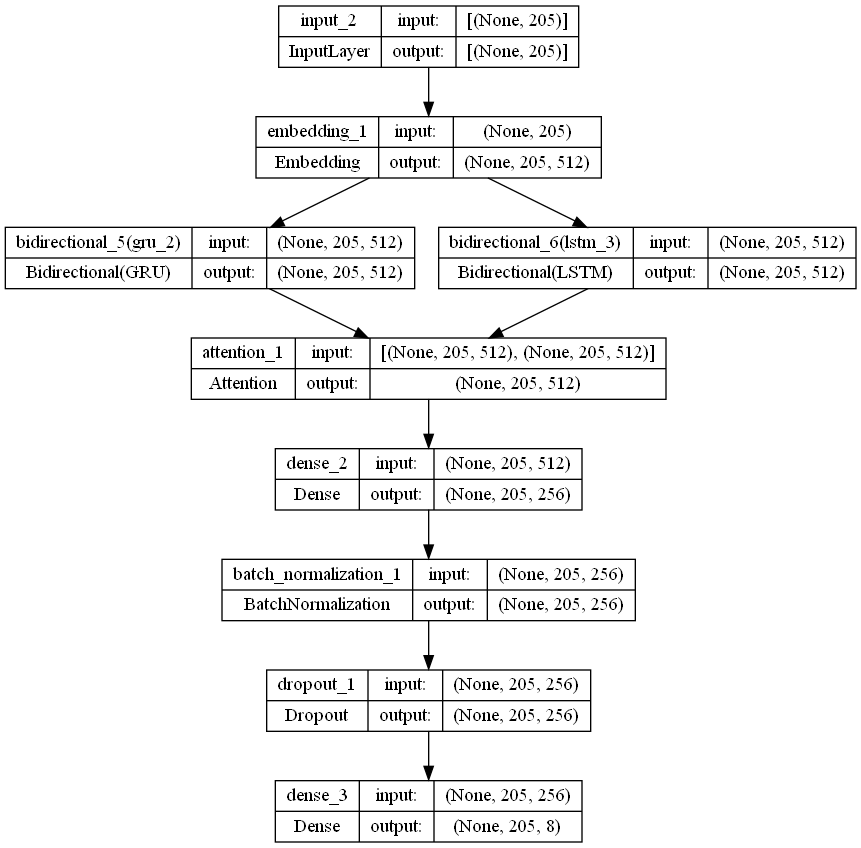

In [76]:
# draw the model
from tensorflow.keras.utils import plot_model
# draw it in the notebook
plot_model(model, show_shapes=True, show_layer_names=True)

In [77]:
# Compile the model
from tensorflow.keras.optimizers import Adam


optimizer = Adam()

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [78]:
def predict(text):
    # remove extra spaces
    new_input_seq = input_tokenizer.texts_to_sequences([text])
    new_input_seq = pad_sequences(new_input_seq, maxlen=max_input_len, padding='post')

    pred_output_seq = model.predict(new_input_seq)
    # set the index 0 of pred_output_seq to -inf for all words [0,this dynamic , 0]

    pred_output_seq = np.argmax(pred_output_seq, axis=-1)

    pred_named_entities = [output_idx2word.get(idx, '') for idx in pred_output_seq[0]]
    print(pred_named_entities)
    # map each word to its predicted named entity
    for word, ner in zip(text.split(), pred_named_entities):
        print(f"{word} -> {ner}")

In [80]:
# Set the number of epochs
num_epochs = 2

history = model.fit(train_input_seq, train_output_seq, validation_data=(val_input_seq, val_output_seq), batch_size=512, epochs=num_epochs)
    

Epoch 1/2
149/149 [==============================] - 79s 533ms/step - loss: 0.2968 - accuracy: 0.9720 - val_loss: 0.0648 - val_accuracy: 0.9903
Epoch 2/2
149/149 [==============================] - 85s 572ms/step - loss: 0.0174 - accuracy: 0.9966 - val_loss: 0.0313 - val_accuracy: 0.9985


In [81]:
import numpy as np

In [82]:
# Use the model to make predictions on new input data
text = "حاجز دير شرف مفتوح"
predict(text)

1/1 [==============================] - 1s 1s/step
['Barr', 'B-LOC', 'I-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
دير -> B-LOC
شرف -> I-LOC
مفتوح -> STAT


In [83]:
# Use the model to make predictions on new input data
text = "حاجز حوارة مسكر"
predict(text)

1/1 [==============================] - 0s 257ms/step
['Barr', 'B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
حوارة -> B-LOC
مسكر -> STAT


In [84]:
# Use the model to make predictions on new input data
text = "حاجز رءؤرء مسكر"
predict(text)

1/1 [==============================] - 0s 243ms/step
['Barr', 'O', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
رءؤرء -> O
مسكر -> STAT


In [86]:
# Set the number of epochs
num_epochs = 2

history = model.fit(train_input_seq, train_output_seq, validation_data=(val_input_seq, val_output_seq), batch_size=512, epochs=num_epochs)
    

Epoch 1/2
149/149 [==============================] - 95s 634ms/step - loss: 0.0038 - accuracy: 0.9994 - val_loss: 0.0091 - val_accuracy: 0.9991
Epoch 2/2
149/149 [==============================] - 93s 624ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0029 - val_accuracy: 0.9990


In [87]:
# Use the model to make predictions on new input data
text = "حاجز دير شرف مفتوح"
predict(text)

1/1 [==============================] - 0s 115ms/step
['Barr', 'B-LOC', 'I-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
دير -> B-LOC
شرف -> I-LOC
مفتوح -> STAT


In [88]:
# Use the model to make predictions on new input data
text = "حاجز حوارة مسكر"
predict(text)

1/1 [==============================] - 0s 165ms/step
['Barr', 'B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
حوارة -> B-LOC
مسكر -> STAT


In [89]:
# Use the model to make predictions on new input data
text = "حاجز رءؤرء مسكر"
predict(text)

1/1 [==============================] - 0s 38ms/step
['Barr', 'Barr', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
رءؤرء -> Barr
مسكر -> STAT


In [91]:
# Set the number of epochs
num_epochs = 2

history = model.fit(train_input_seq, train_output_seq, validation_data=(val_input_seq, val_output_seq), batch_size=512, epochs=num_epochs)
    

Epoch 1/2
149/149 [==============================] - 91s 608ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 5.0510 - val_accuracy: 0.0236
Epoch 2/2
149/149 [==============================] - 84s 562ms/step - loss: 8.9594e-04 - accuracy: 0.9999 - val_loss: 0.4844 - val_accuracy: 0.9994


In [92]:
# Use the model to make predictions on new input data
text = "حاجز دير شرف مفتوح"
predict(text)

1/1 [==============================] - 0s 162ms/step
['Barr', 'B-LOC', 'I-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
دير -> B-LOC
شرف -> I-LOC
مفتوح -> STAT


In [93]:
# Use the model to make predictions on new input data
text = "حاجز حوارة مسكر"
predict(text)

1/1 [==============================] - 0s 39ms/step
['Barr', 'B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
حوارة -> B-LOC
مسكر -> STAT


In [94]:
# Use the model to make predictions on new input data
text = "حاجز رءؤرء مسكر"
predict(text)

1/1 [==============================] - 0s 157ms/step
['Barr', 'O', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
رءؤرء -> O
مسكر -> STAT


In [95]:
# Set the number of epochs
num_epochs = 2
history = model.fit(train_input_seq, train_output_seq, validation_data=(val_input_seq, val_output_seq), batch_size=512, epochs=num_epochs)
    

Epoch 1/2
149/149 [==============================] - 94s 632ms/step - loss: 6.0842e-04 - accuracy: 0.9999 - val_loss: 0.0322 - val_accuracy: 0.9999
Epoch 2/2
149/149 [==============================] - 133s 891ms/step - loss: 4.5541e-04 - accuracy: 0.9999 - val_loss: 0.0162 - val_accuracy: 0.9999


In [96]:
# Use the model to make predictions on new input data
text = "حاجز دير شرف مفتوح"
predict(text)
# Use the model to make predictions on new input data
text = "حاجز حوارة مسكر"
predict(text)
# Use the model to make predictions on new input data
text = "حاجز رءؤرء مسكر"
predict(text)

1/1 [==============================] - 0s 65ms/step
['Barr', 'B-LOC', 'I-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
دير -> B-LOC
شرف -> I-LOC
مفتوح -> STAT
1/1 [==============================] - 0s 42ms/step
['Ba

In [97]:
# Set the number of epochs
num_epochs = 2
history = model.fit(train_input_seq, train_output_seq, validation_data=(val_input_seq, val_output_seq), batch_size=512, epochs=num_epochs)

Epoch 1/2
149/149 [==============================] - 136s 909ms/step - loss: 3.6708e-04 - accuracy: 0.9999 - val_loss: 0.0200 - val_accuracy: 0.9999
Epoch 2/2
149/149 [==============================] - 106s 713ms/step - loss: 3.0529e-04 - accuracy: 0.9999 - val_loss: 0.0748 - val_accuracy: 0.9999


In [98]:
# Use the model to make predictions on new input data
text = "حاجز دير شرف مفتوح"
predict(text)
# Use the model to make predictions on new input data
text = "حاجز حوارة مسكر"
predict(text)
# Use the model to make predictions on new input data
text = "حاجز رءؤرء مسكر"
predict(text)

1/1 [==============================] - 0s 167ms/step
['Barr', 'B-LOC', 'I-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
دير -> B-LOC
شرف -> I-LOC
مفتوح -> STAT
1/1 [==============================] - 0s 95ms/step
['B

In [99]:
# Use the model to make predictions on new input data
text = "اليوم مريت على حاجز دير شرف ولقيتو مسكر"
predict(text)

1/1 [==============================] - 0s 34ms/step
['O', 'O', 'O', 'Barr', 'B-LOC', 'I-LOC', 'O', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
اليوم -> O
مريت -> O
على -> O
حاجز -> Barr
دير -> B-LOC
شرف -> I-LOC
ولقيتو -> O
مسكر -> STAT


In [100]:
# Use the model to make predictions on new input data
text = "حاجز ءئؤئءؤ مسكر"
predict(text)

1/1 [==============================] - 0s 160ms/step
['Barr', 'O', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
ءئؤئءؤ -> O
مسكر -> STAT


In [101]:
# Use the model to make predictions on new input data
text = " حاجز حوارة مغغلك"
predict(text)

1/1 [==============================] - 0s 31ms/step
['Barr', 'B-LOC', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
حوارة -> B-LOC
مغغلك -> O


In [102]:
# Set the number of epochs
num_epochs = 2
history = model.fit(train_input_seq, train_output_seq, validation_data=(val_input_seq, val_output_seq), batch_size=512, epochs=num_epochs)

Epoch 1/2
149/149 [==============================] - 94s 632ms/step - loss: 2.5365e-04 - accuracy: 1.0000 - val_loss: 9.7253e-04 - val_accuracy: 0.9998
Epoch 2/2
149/149 [==============================] - 77s 517ms/step - loss: 2.1985e-04 - accuracy: 1.0000 - val_loss: 0.0329 - val_accuracy: 0.9999


In [103]:
# Use the model to make predictions on new input data
text = "حاجز دير شرف مفتوح"
predict(text)
# Use the model to make predictions on new input data
text = "حاجز حوارة مسكر"
predict(text)
# Use the model to make predictions on new input data
text = "حاجز رءؤرء مسكر"
predict(text)

1/1 [==============================] - 0s 43ms/step
['Barr', 'B-LOC', 'I-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
دير -> B-LOC
شرف -> I-LOC
مفتوح -> STAT
1/1 [==============================] - 0s 38ms/step
['Ba

In [158]:
# Use the model to make predictions on new input data
text = " مصر مسكر"
predict(text)

1/1 [==============================] - 0s 269ms/step
['B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
مصر -> B-LOC
مسكر -> STAT


In [159]:
# Use the model to make predictions on new input data
text = " حاجز مصر"
predict(text)

1/1 [==============================] - 0s 294ms/step
['Barr', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
مصر -> STAT


In [163]:
# Use the model to make predictions on new input data
text = " محسوم الاردن فاتح "
predict(text)

1/1 [==============================] - 0s 44ms/step
['Barr', 'B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
محسوم -> Barr
الاردن -> B-LOC
فاتح -> STAT


In [166]:
# Use the model to make predictions on new input data
text = " حاجز  اللنبي  فاتح "
predict(text)

1/1 [==============================] - 0s 247ms/step
['Barr', 'B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
اللنبي -> B-LOC
فاتح -> STAT


In [168]:
# Use the model to make predictions on new input data
text ="حاجز الحمرا سالكة"
predict(text)

1/1 [==============================] - 0s 214ms/step
['Barr', 'B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
الحمرا -> B-LOC
سالكة -> STAT


In [170]:
# Use the model to make predictions on new input data
text ="حوارة  سالك"
predict(text)

1/1 [==============================] - 0s 215ms/step
['B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حوارة -> B-LOC
سالك -> STAT


In [171]:
# Use the model to make predictions on new input data
text ="صره سالك دخول وخروج"
predict(text)

1/1 [==============================] - 0s 196ms/step
['B-LOC', 'STAT', 'O', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
صره -> B-LOC
سالك -> STAT
دخول -> O
وخروج -> O


In [172]:
text ="شو وضع حوارة يا اخوان"
predict(text)

1/1 [==============================] - 0s 197ms/step
['O', 'O', 'B-LOC', 'O', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
شو -> O
وضع -> O
حوارة -> B-LOC
يا -> O
اخوان -> O


In [176]:
text ="الانتباه شباب محسوم دير شرف والحمرا زاطمين"
predict(text)

1/1 [==============================] - 0s 177ms/step
['O', 'O', 'Barr', 'B-LOC', 'I-LOC', 'B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
الانتباه -> O
شباب -> O
محسوم -> Barr
دير -> B-LOC
شرف -> I-LOC
والحمرا -> B-LOC
زاطمين -> STAT


In [177]:
# Use the model to make predictions on new input data
text = " حاجز حوارة مغلق"
predict(text)

1/1 [==============================] - 0s 265ms/step
['Barr', 'B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
حوارة -> B-LOC
مغلق -> STAT


In [119]:
# Use the model to make predictions on new input data
text = " حاجز حوارة مغلك"
predict(text)

1/1 [==============================] - 0s 263ms/step
['Barr', 'B-LOC', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
حوارة -> B-LOC
مغلك -> O


In [120]:
# Set the number of epochs
num_epochs = 2
history = model.fit(train_input_seq, train_output_seq, validation_data=(val_input_seq, val_output_seq), batch_size=512, epochs=num_epochs)

Epoch 1/2
149/149 [==============================] - 92s 617ms/step - loss: 1.6769e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 0.9998
Epoch 2/2
149/149 [==============================] - 84s 560ms/step - loss: 1.3915e-04 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9999


In [123]:
# Use the model to make predictions on new input data
text = "كيف شافي شمرون"
predict(text)

1/1 [==============================] - 0s 90ms/step
['O', 'B-LOC', 'I-LOC', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
كيف -> O
شافي -> B-LOC
شمرون -> I-LOC


In [125]:
# Use the model to make predictions on new input data
text = "حاجز حوارة فتحو  دفعة وحدة"
predict(text)

1/1 [==============================] - 0s 369ms/step
['Barr', 'B-LOC', 'STAT', 'O', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
حوارة -> B-LOC
فتحو -> STAT
دفعة -> O
وحدة -> O


In [126]:
# Use the model to make predictions on new input data
text = "بيت فوريك سالك ال اتجاهين"
predict(text)

1/1 [==============================] - 0s 144ms/step
['B-LOC', 'I-LOC', 'STAT', 'I-LOC', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
بيت -> B-LOC
فوريك -> I-LOC
سالك -> STAT
ال -> I-LOC
اتجاهين -> O


In [127]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions for the test set
y_pred = model.predict(val_input_seq)

# Convert predictions and ground-truth labels to flattened arrays
y_pred_flat = np.argmax(y_pred, axis=-1).flatten()
y_true_flat = val_output_seq.flatten()

# Get list of unique labels in the dataset
labels = list(set(y_true_flat))

# Generate classification report for each label
# add the label names to the classification report
output_idx2word

596/596 [==============================] - 18s 30ms/step


{1: 'O', 2: 'B-LOC', 3: 'STAT', 4: 'Barr', 5: 'I-LOC', 6: 'B-ORG', 7: 'I-ORG'}

In [129]:
# Use the model to make predictions on new input data
text = "الجيش الاسرائيلي"
predict(text)

1/1 [==============================] - 0s 375ms/step
['B-ORG', 'B-LOC', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
الجيش -> B-ORG
الاسرائيلي -> B-LOC


In [128]:
print(classification_report(y_true_flat, y_pred_flat, labels=labels))

c:\Users\nasser\.conda\envs\finall\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nasser\.conda\envs\finall\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3810511
           1       1.00      1.00      1.00     58527
           2       0.98      1.00      0.99     15411
           3       1.00      0.99      1.00     11403
           4       1.00      1.00      1.00      5510
           5       1.00      1.00      1.00      3308
           6       1.00      0.98      0.99       956
           7       0.00      0.00      0.00        34

    accuracy                           1.00   3905660
   macro avg       0.87      0.87      0.87   3905660
weighted avg       1.00      1.00      1.00   3905660



c:\Users\nasser\.conda\envs\finall\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:

# print the accuracy
print("Accuracy: ", history.history['accuracy'][-1])
# print the accuracy of validation set
print("Validation Accuracy: ", history.history['val_accuracy'][-1])

Accuracy:  0.9999814629554749
Validation Accuracy:  0.9998812079429626


In [138]:
import numpy as np
# Use the model to make predictions on new input data
text = "أنا على دير شرف سيسسالك"
# remove extra spaces
new_input_seq = input_tokenizer.texts_to_sequences([text])
new_input_seq = pad_sequences(new_input_seq, maxlen=max_input_len, padding='post')

pred_output_seq = model.predict(new_input_seq)
# set the index 0 of pred_output_seq to -inf for all words [0,this dynamic , 0]

pred_output_seq = np.argmax(pred_output_seq, axis=-1)

pred_named_entities = [output_idx2word.get(idx, '') for idx in pred_output_seq[0]]
print(pred_named_entities)
# map each word to its predicted named entity
for word, ner in zip(text.split(), pred_named_entities):
    print(f"{word} -> {ner}")

1/1 [==============================] - 0s 38ms/step
['B-LOC', 'O', 'B-LOC', 'I-LOC', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
أنا -> B-LOC
على -> O
دير -> B-LOC
شرف -> I-LOC
سيسسالك -> O


In [57]:
# # save the model
# model.save('../models/ner/ner_model.h5')

In [58]:
# # save the tokenizer
# import joblib
# joblib.dump(input_tokenizer, '../models/ner/input_tokenizer.pkl')

['../models/ner/input_tokenizer.pkl']

In [60]:
# # save the output_idx2word using joblib
# joblib.dump(output_idx2word, '../models/ner/output_idx2word.pkl')


['../models/ner/output_idx2word.pkl']

In [148]:
# read the model
from tensorflow.keras.models import load_model
model = load_model('../models/ner/ner_model.h5')
# read the tokenizer
import joblib
input_tokenizer = joblib.load('../models/ner/input_tokenizer.pkl')
# read the output_idx2word
output_idx2word = joblib.load('../models/ner/output_idx2word.pkl')
    

In [151]:
# Use the model to make predictions on new input data
text = "حاجز الاردن مسكر"
predict(text)

1/1 [==============================] - 0s 34ms/step
['Barr', 'B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
الاردن -> B-LOC
مسكر -> STAT


In [157]:
# Use the model to make predictions on new input data
text = "محسوم الاردن زاطم"
predict(text)

1/1 [==============================] - 0s 255ms/step
['Barr', 'B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
محسوم -> Barr
الاردن -> B-LOC
زاطم -> STAT


In [139]:
import numpy as np
# Use the model to make predictions on new input data
text = "حاجز صرة ازمة للخارجين من نابلس"
# remove extra spaces
new_input_seq = input_tokenizer.texts_to_sequences([text])
new_input_seq = pad_sequences(new_input_seq, maxlen=205, padding='post')

pred_output_seq = model.predict(new_input_seq)
# set the index 0 of pred_output_seq to -inf for all words [0,this dynamic , 0]

pred_output_seq = np.argmax(pred_output_seq, axis=-1)


pred_named_entities = [output_idx2word.get(idx, '') for idx in pred_output_seq[0]]
print(pred_named_entities)
# map each word to its predicted named entity
for word, ner in zip(text.split(), pred_named_entities):
    print(f"{word} -> {ner}")

1/1 [==============================] - 0s 332ms/step
['Barr', 'B-LOC', 'STAT', 'O', 'O', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
صرة -> B-LOC
ازمة -> STAT
للخارجين -> O
من -> O
نابلس -> O
